## Text-classification

[REF](https://github.com/pytorch/ort/blob/3c14f36cdacb15ed0de7ba8559e827e5004c7b1f/torch_ort_inference/torch_ort/ortinferencemodule/ortinferencemodule.py#L109)
```python
self._device = _utils_infer.get_device_from_module(module)


run_options = C.RunOptions()

# Pre-process inputs to make them compatible with onnxruntime
onnx_input_names = [inp.name for inp in self._onnx_models.exported_model.graph.input]
inputs = _utils_infer.get_user_inputs(onnx_input_names, self._flattened_module._input_info, inputs, kwargs, self._device)

io_binding = self._inference_session.io_binding()
_utils._create_iobinding(io_binding, inputs, self._onnx_models.exported_model, self._device)

# Run inference session
self._inference_session.run_with_iobinding(io_binding, run_options)

# Post-process outputs to make them compatible with pytorch
forward_outputs = io_binding._iobinding.get_outputs()

user_outputs = _utils._ortvalues_to_torch_tensor(forward_outputs, self._device)
return _io.unflatten_user_output(self._module_output_schema, user_outputs)
```

## new utils

_need onnxruntime-training_

In [1]:
!pip install onnxruntime onnxruntime-training

Defaulting to user installation because normal site-packages is not writeable
  Using cached onnxruntime-1.12.0-cp39-cp39-manylinux_2_27_x86_64.whl (4.9 MB)
  Using cached onnxruntime_training-1.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (88.8 MB)


In [1]:
import torch
from onnxruntime.capi.onnxruntime_inference_collection import OrtValue
from distutils.version import LooseVersion
from torch.utils.dlpack import to_dlpack
from onnxruntime.capi import _pybind_state as C # needs onnxruntime-training 
from torch._C import _from_dlpack

def _ortvalue_from_torch_tensor(torch_tensor):
    # TODO: Current DLPack doesn't support bool and PyTorch disables converting bool tensor to DLPack in recent commit.
    # https://github.com/pytorch/pytorch/blob/7e7be526c9d9179f35084e9cca5b5c5ad5172100/aten/src/ATen/DLConvertor.cpp#L41
    # We need to convert bool tensor to unit8 tensor to workaround this.
    # DLPack is discussing how to support bool type, we can remove this workaround once both DLPack
    # and PyTorch support bool type.
    # is_bool_tensor = torch_tensor.dtype == torch.bool
    # print(is_bool_tensor)
    # if is_bool_tensor and LooseVersion(torch.__version__) >= LooseVersion("1.10.0"):
    #     torch_tensor = torch_tensor.to(torch.uint8)
    print(torch_tensor.device)
    # if torch_tensor.device.type == "ort":
    #     print("ort device")
    #     return C.aten_ort_tensor_to_ort_value(torch_tensor)
    return C.OrtValue.from_dlpack(to_dlpack(torch_tensor), False)

def _ortvalues_to_torch_tensor(ortvalues, device):
    # if len(ortvalues) == 0:
    #     return []

    # if "ort" == device.type:
    #     if not hasattr(C, "to_aten_ort_device_tensor"):
    #         raise AttributeError("onnxruntime is missing to_aten_ort_device_tensor needed to support device == 'ort'.")
    #     return [C.to_aten_ort_device_tensor(ov) for ov in ortvalues]

    # if not isinstance(ortvalues, C.OrtValueVector):
    #     raise TypeError("ortvalues must be an instance of OrtValueVector not %r." % type(ortvalues))

    res = ortvalues.to_dlpacks(_from_dlpack)
    # bool_indices = ortvalues.bool_tensor_indices()
    # if len(bool_indices):
    #     # DLPack structure does not know for sure if it stores boolean
    #     # or uint8. Method to_dlpacks cannot be used in that case.
    #     # Signature of *dl_packs* is `to_dlpacks(dlp, fct) -> list[torch.Tensor]`.
    #     # And fct is a function with signature `fct(dlp) -> torch.Tensor`.
    #     # Boolean tensors are converted into uint8 tensor with the DLPack protocol.
    #     # Therefore, the function `fct` does not know if the dlpack structure
    #     # is a boolean tensor or a uint8 tensor.
    #     # We could either consider another function as an input in
    #     # `to_dlpacks` or add an argument to `fct(dlp, ortvalue)`.
    #     # Second option makes it impossible to directly use `_from_dlpack` or
    #     # or `from_dlpack` from torch.
    #     # The best option would be to add boolean type in DLDataTypeCode.
    #     for i in range(0, len(bool_indices)):
    #         j = bool_indices[i]
    #         res[j] = res[j].to(torch.bool)

    return res

def get_device_index(device):
    if isinstance(device, str):
        # could be 'cuda:0', 'cuda:1', or 'cpu'. with cpu, set index=0
        device = torch.device(device)
    elif isinstance(device, int):
        return device
    return 0 if device.index is None else device.index


_ortvalue_from_torch_tensor(torch.ones(1,1))

/home/ubuntu/.conda/envs/ort/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


/home/ubuntu/.conda/envs/ort/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_validation.py:118: UserWarning: onnxruntime training package info: package_name: onnxruntime-training
  warnings.warn("onnxruntime training package info: package_name: %s" % package_name)
/home/ubuntu/.conda/envs/ort/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_validation.py:119: UserWarning: onnxruntime training package info: __version__: 1.12.0+cu113
  warnings.warn("onnxruntime training package info: __version__: %s" % version)
/home/ubuntu/.conda/envs/ort/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_validation.py:120: UserWarning: onnxruntime training package info: cuda_version: 11.3
  warnings.warn("onnxruntime training package info: cuda_version: %s" % cuda_version)
/home/ubuntu/.conda/envs/ort/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_validation.py:121: UserWarning: onnxruntime build info: cudart_version: 11030
  warnings.warn("onnxruntime build info: cuda

## manual test

In [ ]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")

io_binding = model.model.io_binding()
# inputs
for key,val in d.items():
  io_binding.bind_ortvalue_input(key, OrtValue(_ortvalue_from_torch_tensor(val)))
# outputs
for name in list(model.model_outputs.keys()):
    io_binding.bind_output(name, model.device.type, device_id=model.device.index)
model.model.run_with_iobinding(io_binding)
# Copy output contents to CPU (if on another device). No-op if already on the CPU.
# Y = io_binding.copy_outputs_to_cpu()[0]
raw_outputs= io_binding._iobinding.get_outputs()
outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)
outputs

In [140]:
payload = "I hate you. I hate you. But i like you"

d = tokenizer(payload, return_tensors="pt")

io_binding = model.model.io_binding()
# inputs
for key,val in d.items():
  io_binding.bind_ortvalue_input(key, OrtValue(_ortvalue_from_torch_tensor(val)))
# outputs
for name in list(model.model_outputs.keys()):
    io_binding.bind_output(name, model.device.type, device_id=get_device_index(model.device))
model.model.run_with_iobinding(io_binding)
# Copy output contents to CPU (if on another device). No-op if already on the CPU.
# Y = io_binding.copy_outputs_to_cpu()[0]
raw_outputs= io_binding._iobinding.get_outputs()
outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)
outputs

[tensor([[-3.7966,  4.0482]])]

## Model test

In [5]:


class IOBindingModel(ORTModelForSequenceClassification):
    def __init__(self, model=None, config=None, **kwargs):
        super().__init__(model, config, **kwargs)
        # create {name:idx} dict for model outputs
        self.model_outputs = {output_key.name: idx for idx, output_key in enumerate(self.model.get_outputs())}
        self.model_inputs = {output_key.name: idx for idx, output_key in enumerate(self.model.get_inputs())}
        self.model_input_names = list(self.model_inputs.keys())
        self.model_output_names = list(self.model_outputs.keys())
        self.run_options = C.RunOptions()
        # leads to Segmentation fault (core dumped)
        # self.io_binding = self.model.io_binding()


    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        **kwargs,
    ):
        self.io_binding = self.model.io_binding()

        # add input io binding
        self.io_binding.bind_ortvalue_input("input_ids", OrtValue(_ortvalue_from_torch_tensor(input_ids)))
        self.io_binding.bind_ortvalue_input("attention_mask", OrtValue(_ortvalue_from_torch_tensor(attention_mask)))
        if token_type_ids is not None:
            self.io_binding.bind_ortvalue_input(
                "token_type_ids", OrtValue(_ortvalue_from_torch_tensor(token_type_ids))
            )

        # add output io binding
        for name in self.model_output_names:
            self.io_binding.bind_output(name, self.device.type, device_id=self.device.index)

        # run inference with binding
        self.model.run_with_iobinding(self.io_binding, self.run_options)
        # Copy output contents to CPU (if on another device). No-op if already on the CPU.
        # Y = io_binding.copy_outputs_to_cpu()[0]
        raw_outputs = self.io_binding._iobinding.get_outputs()
        outputs = _ortvalues_to_torch_tensor(raw_outputs, self.device)

        # clear
        # self.io_binding.clear_binding_inputs()
        # self.io_binding.clear_binding_outputs()
        return SequenceClassifierOutput(logits=outputs[0])



## test

In [3]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")
d

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

{'input_ids': tensor([[ 101, 1045, 5223, 2017,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [18]:
io_model = IOBindingModel.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
io_model.device

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

device(type='cpu')

In [23]:
# payload = "I hate you."
palyoad = "I love you so much. It is incredible what a good person you are. I love you so much. It is incredible what a good person you are."

d = tokenizer(payload, return_tensors="pt")
d

{'input_ids': tensor([[ 101, 1045, 5223, 2017, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [24]:
%timeit io_model(**d)

18.2 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit model(**d)

19.4 ms ± 2.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
io = io_model(**d)
van = model(**d)
print(io.logits)
print(van.logits)

tensor([[ 3.9981, -3.2588]])
tensor([[ 3.9981, -3.2588]])


## Benchmark

In [1]:
from time import perf_counter
import numpy as np

def benchmark(seq_len,model,tokenizer,device,iterations=200):
    # prepare date
    seq_len = "l " * (seq_len - 2)
    payload = tokenizer(seq_len, return_tensors="pt")
    payload = {key:val.to(device) for key,val in payload.items()}
    latencies = []
    # warm up
    for _ in range(10):
        _ = model(**payload)
    # Timed run
    for _ in range(iterations):
        start_time = perf_counter()
        _ =  model(**payload)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_p95_ms = 1000 * np.percentile(latencies,95)
    return {"seq_len":payload["input_ids"].shape[1],"time_avg_ms":time_avg_ms,"time_p95_ms":time_p95_ms}



## CPU

In [ ]:
import pandas as pd

seq_lengths=[8,16,32,64,128,256,512]
res =[]
for seq_len in seq_lengths:
    io = benchmark(seq_len,io_model,tokenizer)
    res.append({**io,"model":"io"})
    
    vanilla = benchmark(seq_len,model,tokenizer)
    res.append({**vanilla,"model":"vanilla"})    

In [31]:
df = pd.DataFrame(res)

df[["seq_len","model","time_avg_ms","time_p95_ms"]].groupby(["seq_len","model"]).head()

,seq_len,model,time_avg_ms,time_p95_ms
0,8,io,21.845188,31.285430
1,8,vanilla,19.478945,25.687145
2,16,io,21.550402,22.859014
3,16,vanilla,21.397938,21.801143
4,32,io,27.146151,28.067425
5,32,vanilla,27.092843,28.878892
6,64,io,37.805838,38.701186
7,64,vanilla,37.629447,38.756979
8,128,io,61.262763,62.647250
9,128,vanilla,61.089302,62.189090


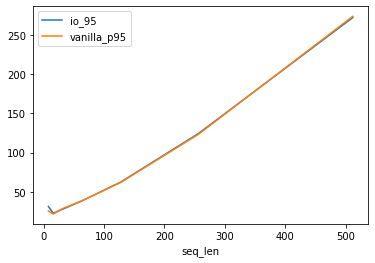

In [32]:
chart_df = pd.merge(df[df.model == 'io'][["seq_len","time_p95_ms"]], df[df.model == 'vanilla'][["seq_len","time_p95_ms"]], on='seq_len')
chart_df = chart_df.rename(columns={"time_p95_ms_x": "io_95", "time_p95_ms_y": "vanilla_p95"})
plt = chart_df.plot(x="seq_len",y=["io_95","vanilla_p95"],kind="line")
plt.figure.savefig('cpu_res.png', dpi=300)


In [33]:
![cpu_res.png](cpu_res.png)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/bin/bash: -c: line 1: syntax error near unexpected token `cpu_res.png'
/bin/bash: -c: line 1: `[cpu_res.png](cpu_res.png)'


# GPU

In [28]:
!pip uninstall onnxruntime onnxruntime-gpu onnxruntime-training torch optimum -y 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Found existing installation: onnxruntime-training 1.11.1+cu113
Uninstalling onnxruntime-training-1.11.1+cu113:
  Successfully uninstalled onnxruntime-training-1.11.1+cu113
Found existing installation: torch 1.11.0+cu113
Uninstalling torch-1.11.0+cu113:
  Successfully uninstalled torch-1.11.0+cu113
Found existing installation: optimum 1.3.0
Uninstalling optimum-1.3.0:
  Successfully uninstalled optimum-1.3.0


the combination below works!!! 

In [29]:
# it seems 1.12.0 doesn't work with cuda11.3
# Inconsistency detected by ld.so: dl-version.c: 205: _dl_check_map_versions: Assertion `needed != NULL' failed!
%pip install onnx==1.11.0 ninja
%pip install torch==1.11.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
%pip install onnxruntime-training==1.12.0+cu113 -f https://download.onnxruntime.ai/onnxruntime_stable_cu113.html
%pip install onnxruntime-gpu==1.12.0+cu113 -f https://download.onnxruntime.ai/onnxruntime_stable_cu113.html
%pip install optimum matplotlib pandas

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu113/torch-1.11.0%2Bcu113-cp39-cp39-linux_x86_64.whl (1637.0 MB)
Note: you may need to restart the kernel to use updated packages.
huggingface/tokenizers: The current p

In [3]:
from onnxruntime import get_available_providers, get_device
import onnxruntime.training
import onnxruntime 

# check available providers
assert 'CUDAExecutionProvider' in get_available_providers(), "ONNX Runtime GPU provider not found. Make sure onnxruntime-gpu is installed and onnxruntime is uninstalled."
assert "GPU" == get_device()

In [4]:
import torch 

device = torch.device("cuda:0")

## manuall test

In [2]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer
from onnxruntime.capi.onnxruntime_inference_collection import OrtValue
import torch 

device = torch.device("cuda:0")
model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
model.to(device)
print(f"model device {model.device}")


payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")

io_binding = model.model.io_binding()
# inputs
for key,val in d.items():
  io_binding.bind_ortvalue_input(key, OrtValue(_ortvalue_from_torch_tensor(val.to(device))))
# outputs
for name in list(model.model_outputs.keys()):
    io_binding.bind_output(name, model.device.type, device_id=model.device.index)
model.model.run_with_iobinding(io_binding)
# Copy output contents to CPU (if on another device). No-op if already on the CPU.
# Y = io_binding.copy_outputs_to_cpu()[0]
raw_outputs= io_binding._iobinding.get_outputs()
print(raw_outputs)
outputs = _ortvalues_to_torch_tensor(raw_outputs, model.device)
outputs

Downloading: 100%|██████████| 710/710 [00:00<00:00, 734kB/s]
Downloading: 100%|██████████| 268M/268M [00:02<00:00, 103MB/s] 


model device cuda:0
cuda:0
cuda:0


[tensor([[ 3.8724, -3.1543]], device='cuda:0')]

# ORTModel

In [3]:
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer
import torch 

device = torch.device("cuda:0")
model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

model.to(device)
print(f"model device {model.device}")
payload = "I hate you"

d = tokenizer(payload, return_tensors="pt")
# model(**d)

Downloading: 100%|██████████| 710/710 [00:00<00:00, 389kB/s]
Downloading: 100%|██████████| 268M/268M [00:02<00:00, 93.3MB/s] 


model device cuda:0


In [6]:
io_model = IOBindingModel.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
io_model.to(device)
io_model.device

Downloading: 100%|██████████| 710/710 [00:00<00:00, 390kB/s]
Downloading: 100%|██████████| 268M/268M [00:02<00:00, 96.2MB/s] 


device(type='cuda', index=0)

In [7]:
d["input_ids"]= d["input_ids"].to(device)
d["attention_mask"]= d["attention_mask"].to(device)

In [ ]:
io_model(**d)

: 

: 

## GPU Benchmark

In [8]:
import torch 
from optimum.onnxruntime import ORTModelForSequenceClassification
from transformers import AutoTokenizer

device = torch.device("cuda:0")
model = ORTModelForSequenceClassification.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
io_model = IOBindingModel.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = AutoTokenizer.from_pretrained("optimum/distilbert-base-uncased-finetuned-sst-2-english")

model.to(device)
io_model.to(device)

Downloading: 100%|██████████| 710/710 [00:00<00:00, 691kB/s]
Downloading: 100%|██████████| 268M/268M [00:03<00:00, 78.1MB/s] 
Downloading: 100%|██████████| 710/710 [00:00<00:00, 440kB/s]
Downloading: 100%|██████████| 268M/268M [00:02<00:00, 96.0MB/s] 


In [9]:
import pandas as pd

seq_lengths=[8,16,32,64,128,256,512]
res =[]
for seq_len in seq_lengths:
    print("seq_len: ",seq_len)
    io = benchmark(seq_len,io_model,tokenizer,device,iterations=500)
    res.append({**io,"model":"io","norm_p95":io["time_p95_ms"]/(seq_len)})
    
    vanilla = benchmark(seq_len,model,tokenizer,device,iterations=500)
    res.append({**vanilla,"model":"vanilla","norm_p95":io["time_p95_ms"]/(seq_len)})    

In [ ]:
df = pd.DataFrame(res)

chart_df = pd.merge(df[df.model == 'io'][["seq_len","time_p95_ms"]], df[df.model == 'vanilla'][["seq_len","time_p95_ms"]], on='seq_len')
chart_df = chart_df.rename(columns={"time_p95_ms_x": "io_p95", "time_p95_ms_y": "vanilla_p95"})
plt = chart_df.plot(x="seq_len",y=["io_p95","vanilla_p95"],kind="line")
plt.figure.savefig('gpu_res.png', dpi=300)

chart_df.head(10)